In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from kdelearn.kde import KDE
from kdelearn.kde_tasks import KDEOutliersDetection
from kdelearn.bandwidth_selection import direct_plugin

In [2]:
data = pd.read_csv("../../data/imdb/IMDb movies.csv")

In [3]:
data.head()

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,NaN,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,537,$ 2250,NaN,NaN,NaN,7.0,7.0
1,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",NaN,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.9,171,NaN,NaN,NaN,NaN,4.0,2.0
2,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,420,$ 45000,NaN,NaN,NaN,24.0,3.0
3,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",...,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2019,NaN,NaN,NaN,NaN,28.0,14.0
4,tt0002199,"From the Manger to the Cross; or, Jesus of Naz...","From the Manger to the Cross; or, Jesus of Naz...",1912,1913,"Biography, Drama",60,USA,English,Sidney Olcott,...,"R. Henderson Bland, Percy Dyer, Gene Gauntier,...","An account of the life of Jesus Christ, based ...",5.7,438,NaN,NaN,NaN,NaN,12.0,5.0


In [4]:
data.columns

Index(['imdb_title_id', 'title', 'original_title', 'year', 'date_published',
       'genre', 'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics'],
      dtype='object')

In [5]:
data.shape

(81273, 22)

# USA

In [6]:
data_usa = data[(data["year"] >= 1970) & (data["country"] == "USA")]

In [7]:
data_usa["year"].max()

2019

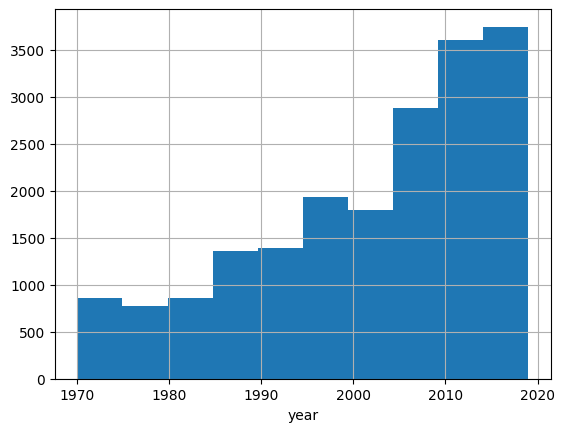

In [8]:
data_usa["year"].hist()
plt.xlabel("year")
plt.show()

In [9]:
data_usa.shape

(19194, 22)

\newpage

# Outliers detection

## duration, budget

In [ ]:
data_usa2 = data_usa[["duration", "budget"]]
data_usa2["budget"] = pd.to_numeric(data_usa2["budget"].str[2:], errors='coerce')
data_usa2 = data_usa2.dropna().reset_index(drop=True)
data_usa2.shape

In [21]:
x_train = data_usa2[["duration", "budget"]].to_numpy(dtype=np.float64)
x_train.shape

(8200, 2)

Najlepszy mnożnik h: 6.500, r: 0.01, Wskaźnik: 0.379


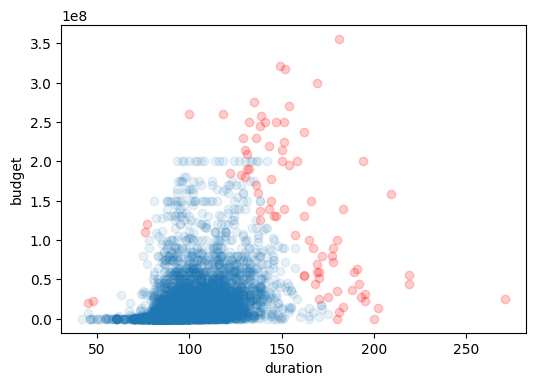

In [22]:
bandwidth = direct_plugin(x_train, stage=2)

metrics_list = []
h_mul_list = []
r_list = []
for h_mul in np.arange(0.5, 10.5, 0.5):
# for h_mul in np.arange(0.5, 2.5, 0.5):
    h_mul = round(h_mul, 3)

    for r in np.arange(0.01, 0.31, 0.01):
#     for r in np.arange(0.01, 0.31, 0.05):
        r = round(r, 3)

        kde = KDE().fit(x_train, bandwidth=bandwidth * h_mul)
        scores = kde.pdf(x_train)
        threshold = np.quantile(scores, r)
        labels_pred = np.where(scores <= threshold, 1, 0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
        scores_out = np.sort(scores[outliers])[-tmp:]
        scores_in = np.sort(scores[inliers])[:tmp]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        h_mul_list.append(h_mul)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepszy mnożnik h: {h_mul_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth*h_mul_list[idx], r=r_list[idx])
labels_pred = outliers_detector.predict(x_train)

plt.figure(figsize=(6, 4))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.2, c="red")
plt.xlabel("duration")
plt.ylabel("budget")
plt.show()

\newpage

## avg_vote, budget

In [ ]:
data_usa3 = data_usa[["avg_vote", "budget"]]
data_usa3["budget"] = pd.to_numeric(data_usa3["budget"].str[2:], errors='coerce')
data_usa3 = data_usa3.dropna().reset_index(drop=True)
data_usa3.shape

In [24]:
x_train = data_usa3[["avg_vote", "budget"]].to_numpy(dtype=np.float64)
x_train.shape

(8200, 2)

Najlepszy mnożnik h: 4.500, r: 0.01, Wskaźnik: 0.415


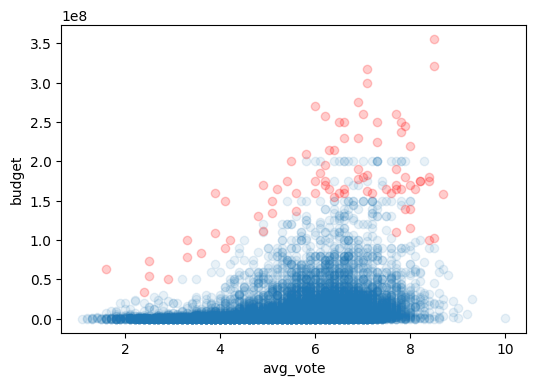

In [25]:
bandwidth = direct_plugin(x_train, stage=2)

metrics_list = []
h_mul_list = []
r_list = []
for h_mul in np.arange(0.5, 10.5, 0.5):
# for h_mul in np.arange(0.5, 2.5, 0.5):
    h_mul = round(h_mul, 3)

    for r in np.arange(0.01, 0.31, 0.01):
#     for r in np.arange(0.01, 0.31, 0.05):
        r = round(r, 3)

        kde = KDE().fit(x_train, bandwidth=bandwidth * h_mul)
        scores = kde.pdf(x_train)
        threshold = np.quantile(scores, r)
        labels_pred = np.where(scores <= threshold, 1, 0)

        n_outliers = labels_pred.sum()
        if n_outliers == 0:
            continue

        inliers = labels_pred == 0
        outliers = labels_pred == 1
        n_outliers = (outliers == 1).sum()
        n_inliers = (outliers == 0).sum()
        tmp = int(np.ceil(0.01 * (n_inliers + n_outliers)))
        scores_out = np.sort(scores[outliers])[-tmp:]
        scores_in = np.sort(scores[inliers])[:tmp]
        metrics = np.sum(scores_out) / np.sum(scores_in)

        metrics_list.append(metrics)
        h_mul_list.append(h_mul)
        r_list.append(r)

# Find minima
idx = np.argmin(metrics_list)
print(f"Najlepszy mnożnik h: {h_mul_list[idx]:.3f}, r: {r_list[idx]}, Wskaźnik: {metrics_list[idx]:.3f}")

#######
outliers_detector = KDEOutliersDetection().fit(x_train, bandwidth=bandwidth*h_mul_list[idx], r=r_list[idx])
labels_pred = outliers_detector.predict(x_train)

plt.figure(figsize=(6, 4))
plt.scatter(x_train[labels_pred==0, 0], x_train[labels_pred==0, 1], alpha=0.1)
plt.scatter(x_train[labels_pred==1, 0], x_train[labels_pred==1, 1], alpha=0.2, c="red")
plt.xlabel("avg_vote")
plt.ylabel("budget")
plt.show()